In [1]:
import numpy as np
import math 

import matplotlib.pyplot as plt
from plotnine import * 
import pandas as pd
%matplotlib inline

from mesa import Model, Agent
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

In [2]:
class Environment(Agent):

    def __init__(self, id, model, pos):
        super().__init__(id,model)
        self.id = id
        self.model = model
        self.pos = posself
        self.state = "EMPTY"

In [3]:
class Termite(Agent):
    
    def __init__(self, id, model, pos, moore=True):
        
        super().__init__(id, model)
        self.id = id
        self.model = model
        self.pos = pos
        self.state = "FORAGE"
        self.moore = moore


    def get_item(self, item):

        this_cell = self.model.grid.get_cell_list_contents([self.pos])
        for agent in this_cell:
            if type(agent) is item:
                return agent


    def random_move(self):
        if self.state == "DROP":
            next_moves = self.model.grid.get_neighborhood(self.pos, False, False)
        else:
            next_moves = self.model.grid.get_neighborhood(self.pos, self.moore, False)
        next_move = self.random.choice(next_moves)
        self.model.grid.move_agent(self, next_move)



    def step(self):

        if self.state == "FORAGE":
            self.random_move()
            environment = self.get_item(Environment)
            if environment.state == "DIRT":
                environment.state = "EMPTY"
                self.state = "LOOK"

        elif self.state == "LOOK":
            self.random_move()
            environment = self.get_item(Environment)
            if environment.state == "DIRT":
                self.state = "DROP"

        elif self.state == "DROP":
            self.random_move()
            environment = self.get_item(Environment)
            if environment.state == "EMPTY":
                environment.state = "DIRT"
                for i in range(5):
                    self.random_move()
                self.state = "FORAGE"


In [4]:
class termiteWorld(Model):

    def __init__(self, height = 40, width = 40, num_dirt = 200, num_termites = 40):
        super().__init__()
        self.h = height
        self.w = width
        self.num_dirt = num_dirt
        self.num_termites = num_termites
        self.piles = 0

        self.schedule = SimultaneousActivation(self)
        self.grid = MultiGrid(height, width, torus=True)

        dirt = 0
        termites = 0
        while dirt != num_dirt and termites != num_termites:
            for x in range(width):
                for y in range(height):
                    dirt = 0
                    environment = Environment(self.next_id(), self, (x, y))
                    if self.random.random() < .2 and dirt <= 200 and environment.state != "DIRT":
                        environment.state = "DIRT"
                        dirt += 1
                    self.grid.place_agent(environment, environment.pos)
                    self.schedule.add(environment)
                    if self.random.random() < .03 and termites < 40:
                        termites += 1
                        termite = Termite(self.next_id(), self, (x,y))
                        self.grid.place_agent(termite, termite.pos)
                        self.schedule.add(termite)
                        
        self.dc = DataCollector({"Piles": lambda m: self.piles})


    def step(self):

        self.schedule.step()
        self.count(self)
        self.dc.collect(self)
        if self.schedule.time > 200:
            self.running = False


    @staticmethod
    def count(self):
        self.piles = 0
        marking = []

        def recursion(x, y):
            for spot in self.grid.get_neighborhood((x, y), False, True):
                agents = self.grid.get_cell_list_contents([spot])
                for a in agents:
                    if type(a) == Environment:
                        if a.state == "DIRT" and marking[spot[0]][spot[1]] == False:
                            marking[spot[0]][spot[1]] = True
                            recursion(spot[0], spot[1])
        for x in range(self.w):
            y = []
            for _ in range(self.h):
                y.append(False)
            marking.append(y)
        for x in range(self.w):
            for y in range(self.h):
                spot_agents = self.grid.get_cell_list_contents([(x,y)])
                for agent in spot_agents:
                    if type(agent) == Environment:
                        if agent.state == "DIRT" and marking[x][y] == False:
                            self.piles += 1
                            recursion(x,y)


In [5]:
termites = termiteWorld()
termites.run_model()
results = termites.dc.get_model_vars_dataframe()
results

,Piles
0,196
1,195
2,194
3,190
4,188
...,...
196,98
197,97
198,97
199,97


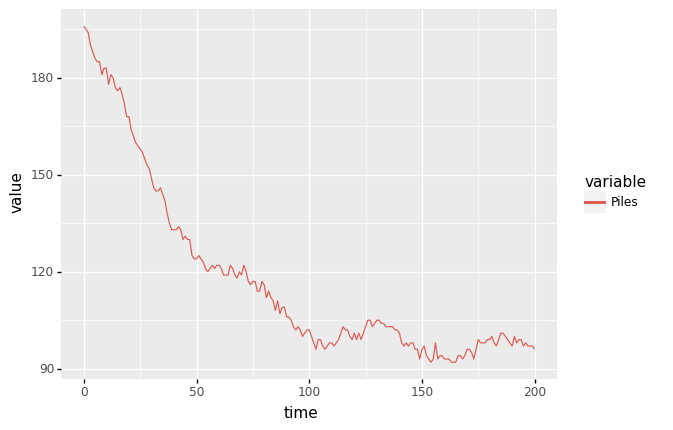

<ggplot: (-9223371906901405156)>

In [6]:
results["time"] = np.linspace(0, len(results) - 1, len(results))
resultsmelt = pd.melt(results, id_vars=["time"], value_vars=["Piles"])
ggplot(resultsmelt, aes(x="time", y="value", color="variable")) \
+ geom_line()

This model shows how quickly the termites are able to group dirt together and how they can work both independently yet help eachother out. 